In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('trainV2.csv')

- **groupId** - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **matchId** - Integer ID to identify match. There are no matches that are in both the training and testing set.
- **assists** - Number of enemy players this player damaged that were killed by teammates.
- **boosts** - Number of boost items used.
- **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
- **DBNOs** - Number of enemy players knocked.
- **headshotKills** - Number of enemy players killed with headshots.
- **heals** - Number of healing items used.
- **killPlace** - Ranking in match of number of enemy players killed.
- **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
- **kills** - Number of enemy players killed.
- **killStreaks** - Max number of enemy players killed in a short amount of time.
- **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **numGroups** - Number of groups we have data for in the match.
- **revives** - Number of times this player revived teammates.
- **rideDistance** - Total distance traveled in vehicles measured in meters.
- **roadKills** - Number of kills while in a vehicle.
- **swimDistance** - Total distance traveled by swimming measured in meters.
- **teamKills** - Number of times this player killed a teammate.
- **vehicleDestroys** - Number of vehicles destroyed.
- **walkDistance** - Total distance traveled on foot measured in meters.
- **weaponsAcquired** - Number of weapons picked up.
- **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

## Kill count investigation

In [3]:
print("The average kill count in this dataset is: {:.3f}.\n90% of people have {} kills or less.\nThe highest kill count is {}.".format(train['kills'].mean(),train['kills'].quantile(0.9), train['kills'].max()))

The average kill count in this dataset is: 0.925.
90% of people have 3.0 kills or less.
The highest kill count is 72.


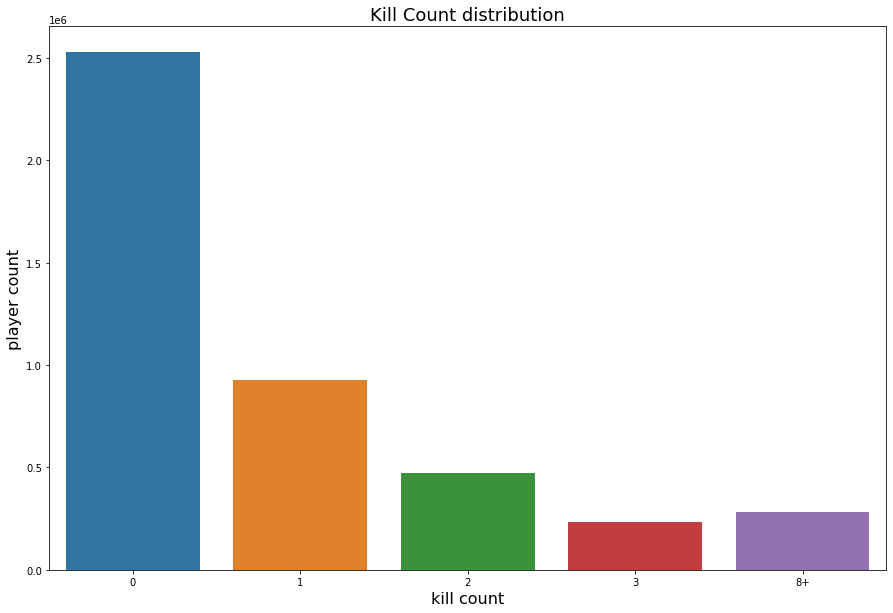

In [4]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.90)] = '8+' #those kills that're higher than 90% will be plotted as > 8
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count distribution", fontsize=18)
plt.xlabel('kill count',fontsize=16)
plt.ylabel('player count',fontsize=16)
plt.show()

Apparently, the majority of players didn't get to make a single kill. Let's investigate how much damage is dealt by them.

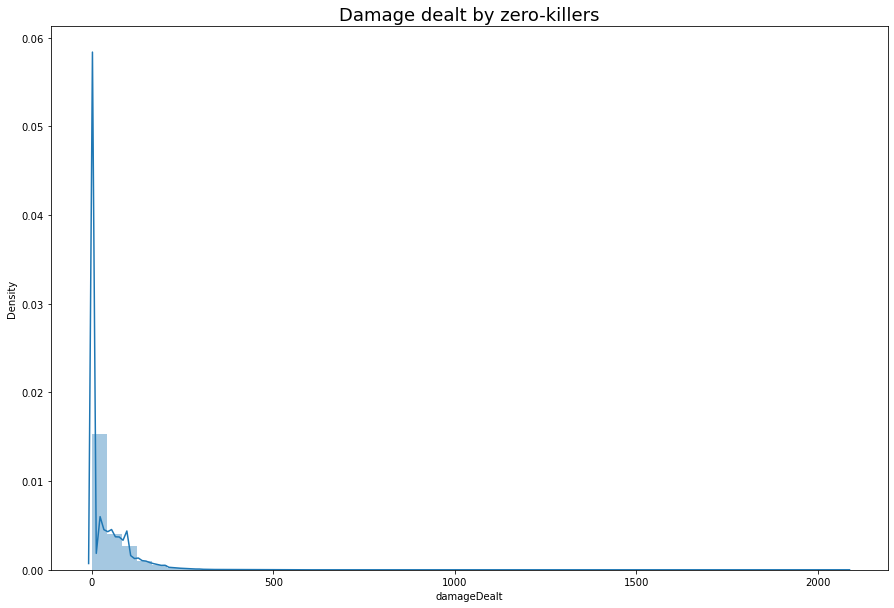

In [5]:
data = train.copy()
data = data[data['kills']==0] #pick zero-killers only
plt.figure(figsize=(15,10))
sns.distplot(data['damageDealt'])
plt.title('Damage dealt by zero-killers', fontsize=18)
plt.show()

Apparently, there're alot of zero-killers aren't able to damage other player without killing.

But, wouldn't it be interesting if there's someone who wins by chance without getting any kills or didn't deal any damage?

Let's investigate the exceptions!

In [6]:
print("Players who win without killing: {} ({:.2f}%)".format(len(data[data['winPlacePerc']==1]),100*len(data[data['winPlacePerc']==1])/len(train)))                     

Players who win without killing: 16666 (0.37%)


In [7]:
data1 = train[train['damageDealt']==0].copy()

In [8]:
print("Players who win without damaging: {} ({:.2f}%)".format(len(data1[data1['winPlacePerc']==1]),100*len(data1[data1['winPlacePerc']==1])/len(train)))                     

Players who win without damaging: 4770 (0.11%)


In [9]:
data_superkillers = train.copy()
data_superkillers = data_superkillers[data_superkillers['kills'] > data_superkillers['kills'].quantile(0.90)]
print("The average damage dealt by top killers is approximately: {}({:.2f}%)".format(len(data_superkillers[data_superkillers['winPlacePerc']==1]),100*len(data_superkillers[data_superkillers['winPlacePerc']==1])/len(train)))

The average damage dealt by top killers is approximately: 55289(1.24%)


## Kills VS Win placement

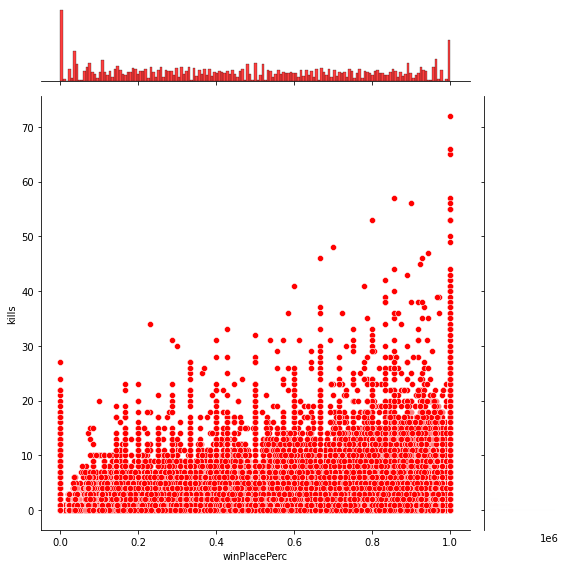

In [10]:
sns.jointplot(x="winPlacePerc", y="kills", data = train, height=8, color='r')

To put it simply, it's more likely for the player to win if he/she kills more.

Let's group players based on kill counts(0, 1-2, 3-5, 6-10, 10+).

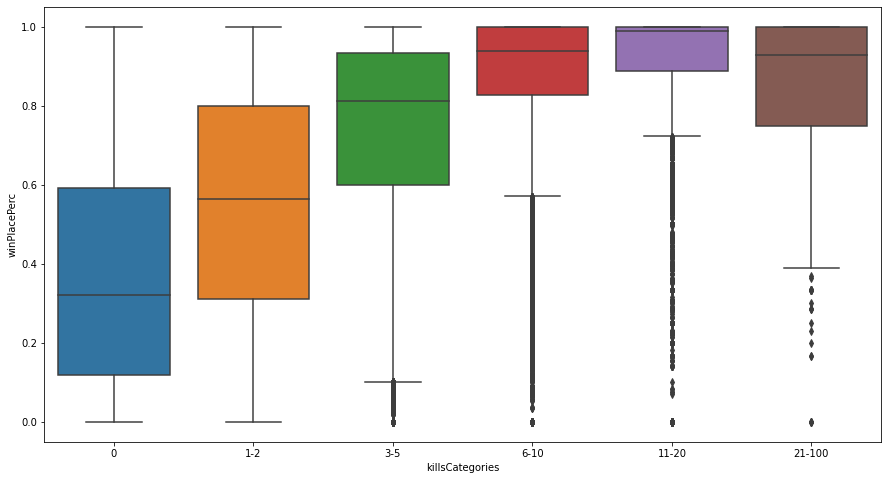

In [11]:
kills = train.copy()
bins = [-1,0,2,5,10,20,100]
group_names = ['0','1-2','3-5','6-10','11-20','21-100']
kills['killsCategories'] = pd.cut(kills['kills'], bins, labels=group_names)
plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

## Distance walked investigation


In [12]:
print("The average distance walked is: {:.3f}m\n99% of people have walked {:.3f}m\nLongest distance walked: {:.3f}m".format(train['walkDistance'].mean(),train['walkDistance'].quantile(0.99),train['walkDistance'].max()))                      

The average distance walked is: 1154.218m
99% of people have walked 4396.000m
Longest distance walked: 25780.000m


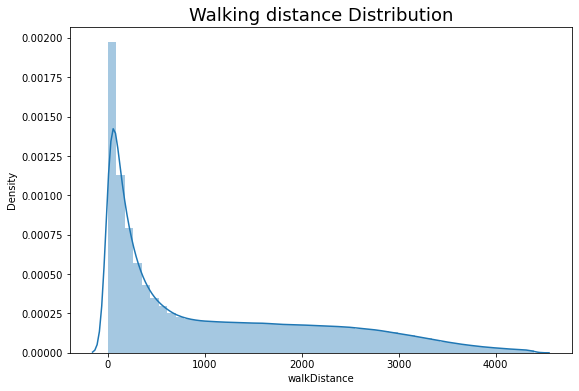

In [13]:
data = train.copy()
data = data[data['walkDistance']<train['walkDistance'].quantile(0.99)]
#pick top 1% of walker only, 
#the .copy() makes sure we don't mess with the original data
plt.figure(figsize=(9,6))
plt.title("Walking distance Distribution",fontsize=18)
sns.distplot(data['walkDistance'])
plt.show()

In [14]:
print("{} players({:.2f}%) walked 0m.\nWhich is utter nonsense because they die before taking a step. \nIt's more likely they left the game early.".format(len(data[data['walkDistance']==0]), 100*len(data[data['walkDistance']==0])/len(train)))                 

99603 players(2.24%) walked 0m.
Which is utter nonsense because they die before taking a step. 
It's more likely they left the game early.


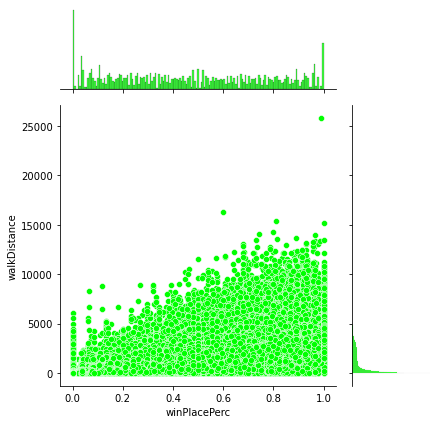

In [15]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=6, ratio=3, color="lime")
plt.show()

It's very likely that the champion walks a lot.

In [16]:
print("The average distance driven: {:.2f}m\n99% of players have driven: {}m or less\nThe longest distance driven: {:.2f}m".format(train['rideDistance'].mean(),train['rideDistance'].quantile(0.99),train['rideDistance'].max()))                                                           

The average distance driven: 606.12m
99% of players have driven: 6966.0m or less
The longest distance driven: 40710.00m


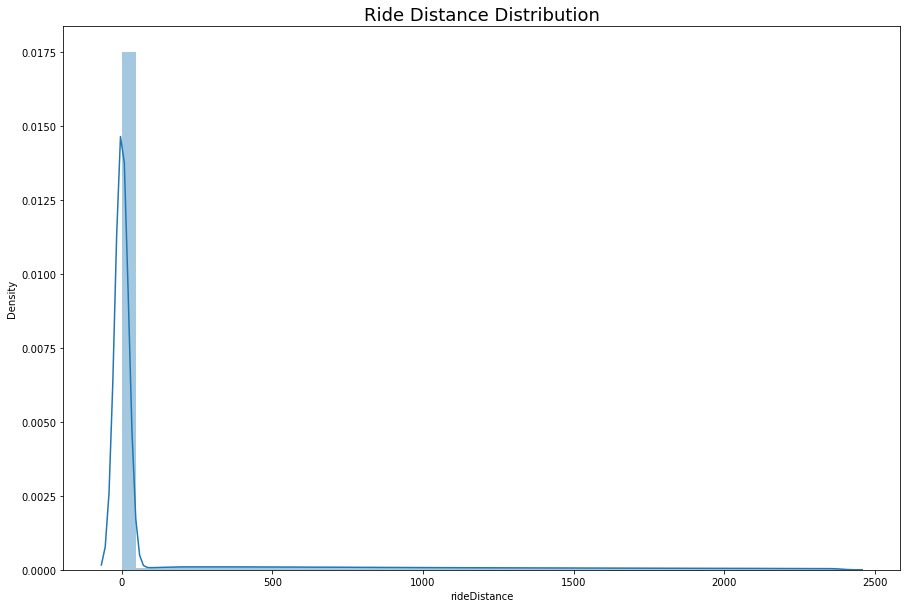

In [17]:
data = train.copy()
data = data[data['rideDistance']<train['rideDistance'].quantile(0.9)] #top10%
plt.figure(figsize=(15,10))
plt.title("Ride Distance Distribution", fontsize=18)
sns.distplot(data['rideDistance'])
plt.show()

wow, so many people drive so little distance. How many are they?

In [18]:
print("{} players ({:.2f}%) have driven for 0m.".format(len(data[data['rideDistance']==0]), 100*len(data[data['rideDistance']==0])/len(train)))                 

3309429 players (74.42%) have driven for 0m.


## Healers and Boosters

In [19]:
print("The average person uses {:.1f} heal items, 99% of people use {} or less.".format(train['heals'].mean(), train['heals'].quantile(0.99)))
print("The average person uses {:.1f} boost items, 99% of people use {} or less.".format(train['boosts'].mean(), train['boosts'].quantile(0.99)))

The average person uses 1.4 heal items, 99% of people use 12.0 or less.
The average person uses 1.1 boost items, 99% of people use 7.0 or less.


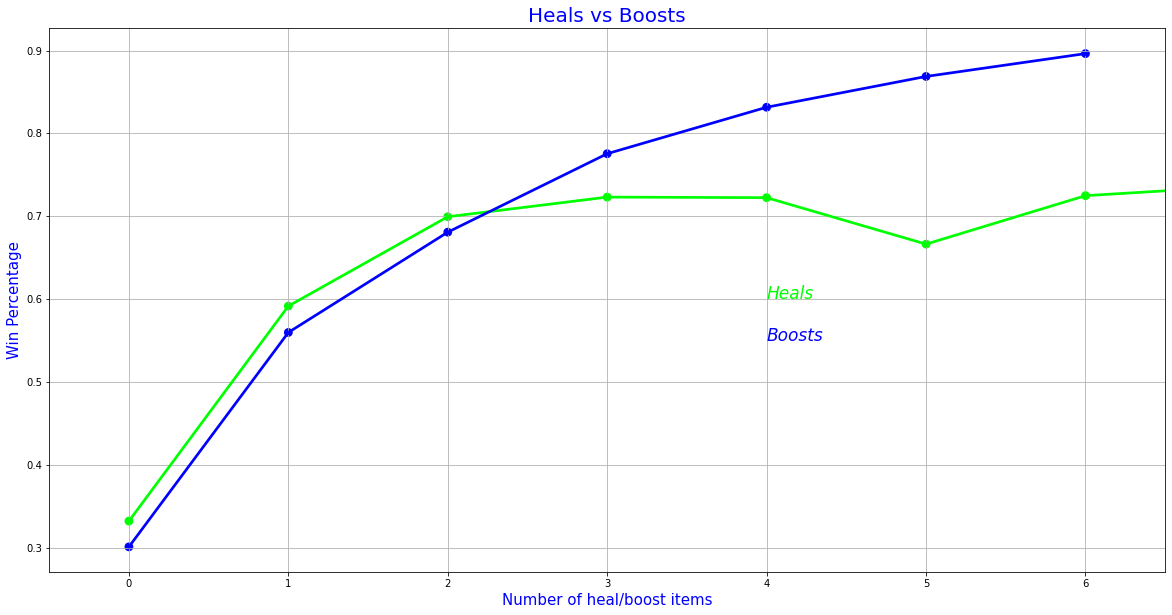

In [20]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)] #pick 99%
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

So healing and boosting, definitely are correlated with winPlacePerc. Boosting is more.
In every plot, there is an abnormal behavior when values are 0.

In [21]:
train['boosts_per_walking_distance'] = train['boosts']/(train['walkDistance']+1)
train['boosts_per_walking_distance'].fillna(0, inplace=True)
train['heals_per_walking_distance'] = train['heals']/(train['walkDistance']+1)
train['heals_per_walking_distance'].fillna(0, inplace=True)
train[['walkDistance','boosts','boosts_per_walking_distance','heals','heals_per_walking_distance']][40:45]

,walkDistance,boosts,boosts_per_walking_distance,heals,heals_per_walking_distance
40,327.30,1,0.003046,1,0.003046
41,128.80,0,0.000000,0,0.000000
42,52.52,0,0.000000,0,0.000000
43,534.10,1,0.001869,0,0.000000
44,2576.00,4,0.001552,6,0.002328


## Solos, Duos and Squads

In [22]:
solos = train[train['numGroups']>50]
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)]
squads = train[train['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}%) duo games and {} ({:.2f}%) squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train)))

There are 709111 (15.95%) solo games, 3295326 (74.10%) duo games and 442529 (9.95%) squad games.


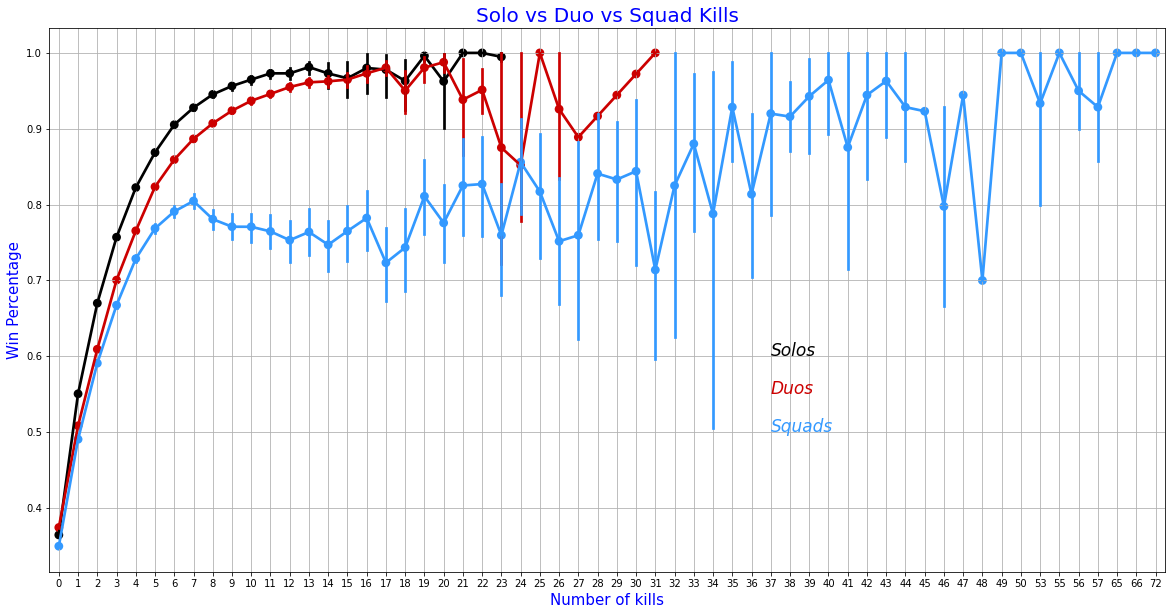

In [23]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
plt.text(37,0.6,'Solos',color='black',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='#3399FF',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

As you can see, as the number of kills increases, the win% increases generally.

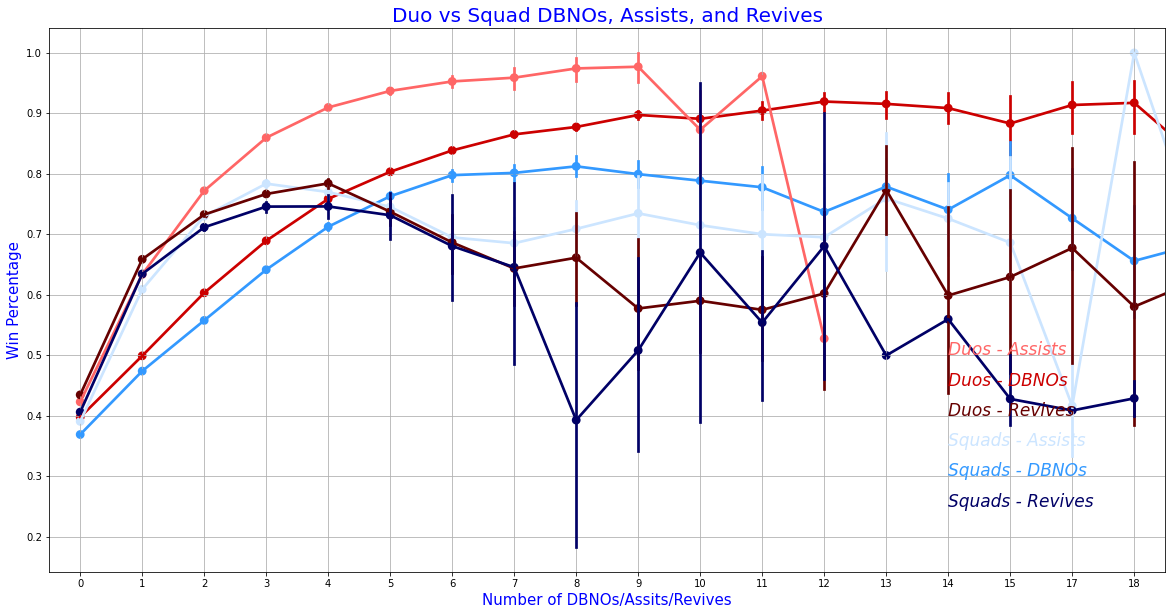

In [24]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,color='#CC0000',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=duos,color='#FF6666',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squads,color='#CCE5FF',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duos,color='#660000',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squads,color='#000066',alpha=0.8)
plt.text(14,0.45,'Duos - DBNOs',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(14,0.5,'Duos - Assists',color='#FF6666',fontsize = 17,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='#660000',fontsize = 17,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='#3399FF',fontsize = 17,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='#CCE5FF',fontsize = 17,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='#000066',fontsize = 17,style = 'italic')
plt.xlabel('Number of DBNOs/Assits/Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Duo vs Squad DBNOs, Assists, and Revives',fontsize = 20,color='blue')
plt.grid()
plt.show()

If your partner/teammate who shares the identical matchId as you gets DBNOs/ revives/assists it indirectly contributes to the win%.

In [25]:
train['team'] = [1 if i>50 else 2 if (i>25 & i<=50) else 4 for i in train['numGroups']]

In [26]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,boosts_per_walking_distance,heals_per_walking_distance,team
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.00,0,0,244.80,1,1466,0.4444,0.0,0.0,2
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,11.04,0,0,1434.00,5,0,0.6400,0.0,0.0,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.00,0,0,161.80,2,0,0.7755,0.0,0.0,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.00,0,0,202.70,3,0,0.1667,0.0,0.0,2
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.00,0,0,49.75,2,0,0.1875,0.0,0.0,1


# Thank you for reading my project. I know it looks shabby, because it's my first personal project. Once again, much thanks!